In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
import os
print("Current working directory is: ", os.getcwd())

Current working directory is:  /home/aabker/mlops/development


Read DataFrame

In [3]:
df = pd.read_csv("datasets/traffic.csv")

Explore Dataset

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,Rush Hour,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,1,5545
1,NaN,289.36,0.0,0.0,75,Clouds,0,4516
2,NaN,289.58,0.0,0.0,90,Clouds,0,4767
3,NaN,290.13,0.0,0.0,90,Clouds,0,5026
4,NaN,291.14,0.0,0.0,75,Clouds,0,4918


In [5]:
df.isnull().sum()

holiday           48143
temp                  0
rain_1h               0
snow_1h               0
clouds_all            0
weather_main          0
Rush Hour             0
traffic_volume        0
dtype: int64

In [6]:
df.dtypes

holiday            object
temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
weather_main       object
Rush Hour           int64
traffic_volume      int64
dtype: object

In [7]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']
print("Numerical columns: ", num_cols)
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
print("Categorical columns: ", cat_cols)


Numerical columns:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'Rush Hour', 'traffic_volume']
Categorical columns:  ['holiday', 'weather_main']


In [8]:
#Explore categorical columns

for col in cat_cols:
    print(f"Unique values for {col} column: ", df[col].unique())

Unique values for holiday column:  [nan 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
Unique values for weather_main column:  ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']


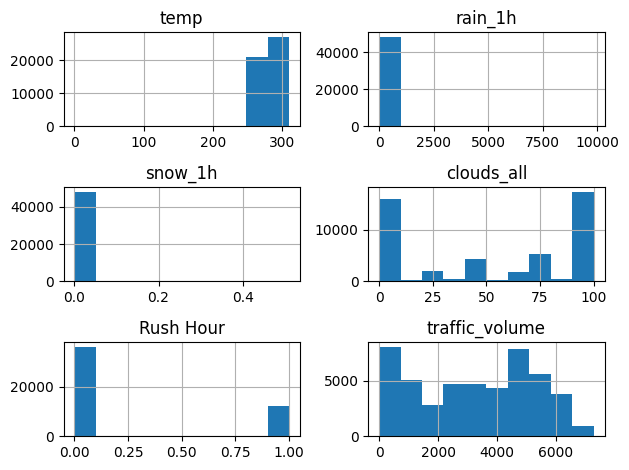

In [9]:
#Checking data ditribution for numerical columns
df[num_cols].hist()
plt.tight_layout()
plt.show()

Feature Engineering

In [10]:
#We can drop holiday column as it has too many missing values
df = df.drop('holiday', axis = 1)
df.shape

(48204, 7)

In [11]:
# df = pd.get_dummies(df, columns = ['weather_main'], prefix = 'weather')
# dummy_cols = [col for col in df.columns if 'weather' in col]
# df[dummy_cols] = df[dummy_cols].astype(int)

In [12]:
df.head(1)

,temp,rain_1h,snow_1h,clouds_all,weather_main,Rush Hour,traffic_volume
0,288.28,0.0,0.0,40,Clouds,1,5545


Features Selection

In [13]:
X = df.drop('traffic_volume', axis = 1)
y = df['traffic_volume']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [15]:
len(X_train),  len(X_val), len(X_test)

(30850, 7713, 9641)

In [16]:
dv = DictVectorizer()

X_train_dicts = X_train.to_dict(orient= 'records')
X_val_dicts = X_val.to_dict(orient= 'records')
X_test_dicts = X_test.to_dict(orient= 'records')

X_train = dv.fit_transform(X_train_dicts)
X_val = dv.transform(X_val_dicts)
X_test = dv.transform(X_test_dicts)

In [17]:
# Initialize MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [19]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared= False)

1850.1245182675354

/tmp/ipykernel_4849/1982906679.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_4849/1982906679.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


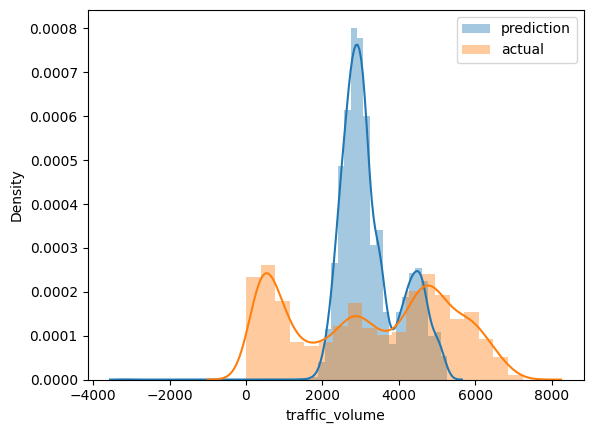

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')
plt.legend()
plt.show()

Save Model

In [21]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, scaler, lr), f_out)